# Building an image detection server with gluoncv
In this notebook, we deploy a pre-trained image detection model
 1. We first import a model from the gluon model zoo locally on the notebook, that we then compress and send to S3
 1. We then use the SageMaker MXNet Serving feature to deploy the model to a real-time managed endpoint. It uses the model artifact that we previously loaded to S3.
 1. We query the endpoint and visualize detection results


* **More on `gluon` and `gluoncv`:**
 * [gluon](https://mxnet.incubator.apache.org/api/python/docs/api/gluon/index.html)** is the imperative python front-end of the Apache MXNet deep learning framework. Gluon notably features specialized toolkits helping reproducing state-of-the-art architectures: [gluon-cv](https://gluon-cv.mxnet.io/), [gluon-nlp](https://gluon-nlp.mxnet.io/), [gluon-ts](https://gluon-ts.mxnet.io/). Gluon also features a number of excellent end-to-end tutorial mixing science with code such as [D2L.ai](https://classic.d2l.ai/) and [The Straight Dope](https://gluon.mxnet.io/)
 * [gluoncv](https://gluon-cv.mxnet.io/contents.html) is an efficient computer vision toolkit written on top of `gluon` and MXNet aiming to make state-of-the-art vision research reproducible. 

* This specific demo has been developed on the `conda_mxnet_p36` kernel of a SageMaker `ml.c5.2xlarge` Notebook instance

**This sample is provided for demonstration purposes, make sure to conduct appropriate testing if derivating this code for your own use-cases!**

In [2]:
! pip install gluoncv=='0.6.0'

     |████████████████████████████████| 693 kB 38.8 MB/s eta 0:00:01
  Attempting uninstall: gluoncv
    Found existing installation: gluoncv 0.8.0
    Uninstalling gluoncv-0.8.0:
      Successfully uninstalled gluoncv-0.8.0
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import datetime
import json
import math
import os
import shutil
import subprocess as sb
import tarfile

import boto3
import gluoncv
from gluoncv import model_zoo, data, utils
from matplotlib import pyplot as plt
import mxnet as mx
from mxnet import gluon, image, nd

# import SageMaker tools
import sagemaker
from sagemaker import get_execution_role
from sagemaker.mxnet.model import MXNetModel

sess = sagemaker.Session()

bucket = sess.default_bucket()  # We use this bucket to store model weights - don't hesitate to change.
print('using bucket ' + bucket)

using bucket sagemaker-us-east-1-217780494771


## Test a pre-trained detection model, locally
gluon model zoo https://mxnet.incubator.apache.org/api/python/gluon/model_zoo.html contains a variety of models.
In this demo we use a YoloV3 detection model (Redmon et Farhadi). More about YoloV3:
* paper https://pjreddie.com/media/files/papers/YOLOv3.pdf
* Website https://pjreddie.com/darknet/yolo/

Gluoncv model zoo contains a number of architectures with different performances in terms of speed and accuracy. If you are looking for speed or accuracy, don't hesitate to change the model

In [4]:
model_name = 'yolo3_darknet53_coco'
net = model_zoo.get_model(model_name, pretrained=True)

100%|██████████| 224190/224190 [00:04<00:00, 48460.81KB/s]


The model we downloaded above is trained on the COCO dataset and can detect 80 classes. In this demo, we restrict the model to detect only specific classes of interest.
This idea is derived from the official gluoncv tutorial: https://gluon-cv.mxnet.io/build/examples_detection/skip_fintune.html


COCO contains the following classes:

In [5]:
print('coco classes: ', net.classes)

coco classes:  ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [6]:
# in this demo we reset the detector to the "person" class

classes = ['person']

net.reset_class(classes=classes, reuse_weights=classes)
print('new classes: ', net.classes)

net.hybridize()  # hybridize to optimize computation

new classes:  ['person']


Test locally

In [7]:
# gather couple public images
images = ['https://cdn.pixabay.com/photo/2017/06/09/05/17/person-2385787_960_720.jpg',
          'https://cdn.pixabay.com/photo/2019/11/04/01/11/cellular-4599956_960_720.jpg',
          'https://cdn.pixabay.com/photo/2016/03/09/09/22/workplace-1245776_1280.jpg',
          'https://cdn.pixabay.com/photo/2017/07/31/21/04/people-2561053_1280.jpg',
          'https://cdn.pixabay.com/photo/2016/08/01/20/13/girl-1561989_1280.jpg',
          'https://cdn.pixabay.com/photo/2015/01/08/18/29/entrepreneur-593358_1280.jpg',
          'https://cdn.pixabay.com/photo/2014/05/03/00/50/flower-child-336658_1280.jpg',
          'https://cdn.pixabay.com/photo/2014/07/31/23/49/guitarist-407212_1280.jpg',
          'https://upload.wikimedia.org/wikipedia/commons/thumb/4/48/Cyprus_national_football_team_2012.jpg/1600px-Cyprus_national_football_team_2012.jpg',
          'https://pixnio.com/free-images/2019/01/13/2019-01-13-09-46-22-1200x900.jpg',
          'https://cdn.pixabay.com/photo/2018/01/24/19/49/people-3104635_1280.jpg']

In [8]:
# download the images locally

pic_folder = 'gluoncv-detector-pics'

sb.call(['mkdir', pic_folder])

shutil.rmtree(os.path.join(os.getcwd(), pic_folder))

for p in images:
    sb.call(['wget', p, '-P', pic_folder])

`gluoncv` comes with built-in pre-processing logic for popular detectors, including YoloV3:

https://gluon-cv.mxnet.io/_modules/gluoncv/data/transforms/presets/yolo.html

https://gluon-cv.mxnet.io/build/examples_detection/demo_yolo.html

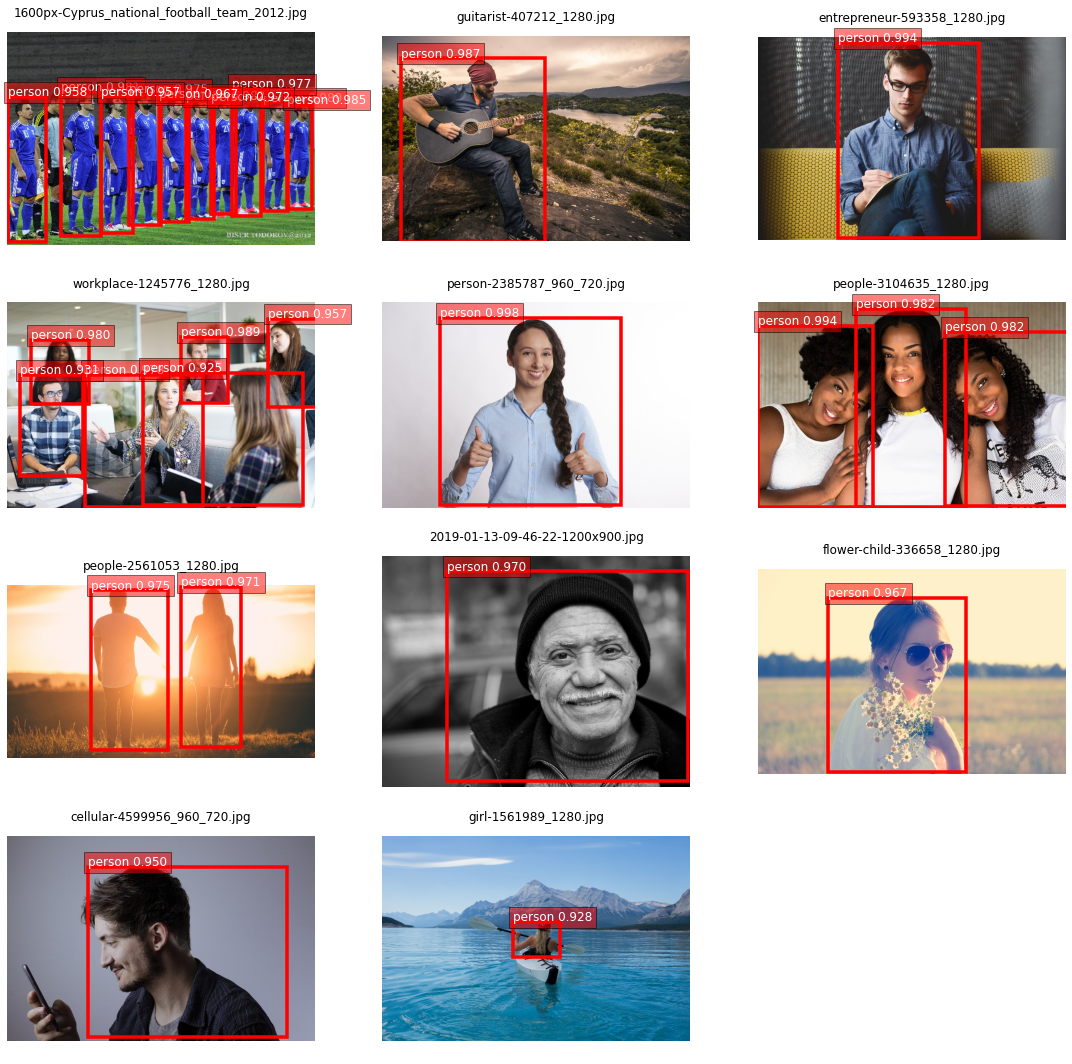

In [9]:
picnames = os.listdir(pic_folder)

n_pics = len(picnames)
n_cols = 3
n_rows = math.ceil(n_pics / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,15))
[ax.axis("off") for ax_dim in axes for ax in ax_dim]
for i, pic in enumerate(picnames):
    curr_col = i % n_cols
    curr_row = i // n_cols
    # download and pre-process image
    #print(pic)
    im_array =  image.imread(os.path.join(pic_folder, pic))
    x, orig_img = data.transforms.presets.yolo.transform_test(im_array)
    
    # forward pass and display
    box_ids, scores, bboxes = net(x)
    ax = utils.viz.plot_bbox(orig_img, bboxes[0], scores[0], box_ids[0], class_names=classes, thresh=0.9, ax=axes[curr_row, curr_col])
    ax.axis("off")
    ax.set_title(pic, pad=15)
fig.tight_layout()    
fig.show();

## Deploy the detection server
 1. We first need to **send the model to S3**, as we will provide the S3 model path to Amazon SageMaker endpoint creation API
 1. We create a **serving script** containing model deserialization code and inference logic
 1. We **deploy the endpoint** with a SageMaker SDK call

### save local model, compress and send to S3

In [10]:
# save the full model (both weights and graph)
net.export(model_name, epoch=0)

In [11]:
# compress
packname = 'model.tar.gz'
tar = tarfile.open(packname, 'w:gz')
tar.add('{}-symbol.json'.format(model_name))
tar.add('{}-0000.params'.format(model_name))
tar.close()

In [12]:
# send to s3
s3 = boto3.client('s3')
s3key = 'detection-artifact'
s3.upload_file(packname, bucket, s3key + '/' + packname)

### Write the detection model in the SageMaker MXNet specification
https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/mxnet/README.rst#deploying-mxnet-models

Amazon SageMaker provides serving container for Sklearn, TensorFlow, PyTorch and Apache MXNet. This is convenient, because we don't have to write web server code: the server is already written, in the case of MXNet it is Multi Model Server ([MMS](https://github.com/awslabs/multi-model-server), also used to server PyTorch in SageMaker) . We just have to provide model deserialization code and serving logic.

The SageMaker MXNet model server breaks request handling into three steps. Each step involves invoking a python function, with information about the request and the return-value from the previous function in the chain:

* input processing, with `input_fn(request_body, request_content_type, model)`
* prediction, with `predict_fn(input_object, model)`
* output processing, with `output_fn(prediction, content_type)`

The full serving specification is documented here https://sagemaker.readthedocs.io/en/stable/using_mxnet.html#deploy-mxnet-models

In our specific example we don't write an `output_fn`, because `predict_fn` outputs an NDArray that can be handled to CSV or JSON by the default `output_fn`

In [13]:
# we will store the script in the 'repo' directory
! mkdir repo

We create a requirements.txt to add an extra dependency to the SageMaker MXNet container (https://github.com/aws/sagemaker-mxnet-serving-container)

In [14]:
%%writefile repo/requirements.txt
gluoncv==0.6.0

Writing repo/requirements.txt


In [15]:
%%writefile repo/detection_server.py

import argparse
import ast
import logging
import os

from gluoncv import model_zoo, data, utils
import mxnet as mx
from mxnet import nd, gluon


def get_ctx():
    "function to get machine hardware context"
    try:
        _ = mx.nd.array([0], ctx=mx.gpu())
        ctx = mx.gpu()
    except:
        try:
            _ = mx.nd.array([0], ctx=mx.eia())
            ctx = mx.eia()
        except: 
            ctx = mx.cpu()
    return ctx


def model_fn(model_dir):
    """
    Load the gluon model. Called once when hosting service starts.
    :param: model_dir The directory where model files are stored.
    :return: a model (in this case a Gluon network)
    
    assumes that the parameters artifact is {model_name}.params
    """
    
    ctx = get_ctx()
    logging.info('Using ctx {}'.format(ctx))
    logging.info('Dir content {}'.format(os.listdir()))
    
    # instantiate net and reset to classes of interest
    net = gluon.nn.SymbolBlock.imports(
        symbol_file=[f for f in os.listdir() if f.endswith('json')][0],
        input_names=['data'],
        param_file=[f for f in os.listdir() if f.endswith('params')][0],
        ctx=ctx)
    
    return net


def input_fn(request_body, request_content_type):
    """prepares the input"""
        
    im_array = mx.image.imdecode(request_body)
    
    # Run YOLO pre-processing on CPU
    x, _ = data.transforms.presets.yolo.transform_test(im_array)
    logging.info('input_fn returns NDArray of shape ' + str(im_array.shape))
    
    return x


def predict_fn(input_object, model):
    """function used for prediction"""
    
    ctx = get_ctx()
    logging.info('Using ctx {}'.format(ctx))
    
    # forward pass and display
    box_ids, scores, bboxes = model(input_object.as_in_context(ctx))
    
    return nd.concat(box_ids, scores, bboxes, dim=2)  # return a single tensor

Writing repo/detection_server.py


### Instantiate model and deploy

In [16]:
model = MXNetModel(
    model_data='s3://{}/{}/{}'.format(bucket, s3key, packname),
    role=get_execution_role(),
    py_version='py3',
    entry_point='detection_server.py',
    source_dir='repo',
    framework_version='1.6.0')

We deploy to an ml.g4dn.xlarge instance featuring a T4 NVIDIA GPU

In [17]:
%%time

endpoint_key = ((model_name + '-detection').replace('_', '-').replace('.', '') + '-' 
                + datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S'))

# this may take 5 to 10min
model.deploy(
    initial_instance_count=1,
    instance_type='ml.g4dn.xlarge',
    endpoint_name=endpoint_key)

------!CPU times: user 16.2 s, sys: 2.71 s, total: 18.9 s
Wall time: 3min 18s


## Submit image requests to the detection server

In [11]:
# instantiate a predictor
predictor = sagemaker.predictor.Predictor(endpoint_name=endpoint_key) # ,content_type='image/jpeg')

In [28]:
def detect(pic, predictor):
    """elementary function to send a picture to a predictor"""
    
    with open(pic, 'rb') as image:
        f = image.read()

    tensor = nd.array(json.loads(predictor.predict(f)))
    box_ids, scores, bboxes = tensor[:,:,0], tensor[:,:,1], tensor[:,:,2:]
    return box_ids, scores, bboxes

In [29]:
%%time

# test

pic = 'girl-1561989_1280.jpg'

box_ids, scores, bboxes = detect(os.path.join(pic_folder, pic), predictor)

CPU times: user 10.6 ms, sys: 4.44 ms, total: 15.1 ms
Wall time: 150 ms


<AxesSubplot:>

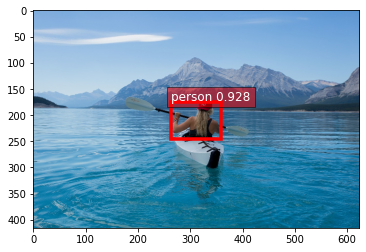

In [30]:
# for local viz we need to resize local pic to the server-side resize
_, orig_img = data.transforms.presets.yolo.load_test(os.path.join(pic_folder, pic))
utils.viz.plot_bbox(orig_img, bboxes[0], scores[0], box_ids[0], class_names=classes, thresh=0.9)

Unsuprisingly this works as well! The main difference with the first demo done locally at the top of the notebook is that we now have a permanently up, remote ML model server reachable with API, along with server and hardware monitoring available in Cloudwatch

## Use the detection server for video data

In [13]:
import time
import gluoncv as gcv
from gluoncv.utils import try_import_cv2
from gluoncv import utils
cv2 = try_import_cv2()
import mxnet as mx
from mxnet import gluon, image, nd
import boto3
import sagemaker
import json
import os

In [35]:
# Load the yolov3 model from gluoncv
model_name = 'yolo3_darknet53_coco'
net = gcv.model_zoo.get_model(model_name, pretrained=True)
# get the classes from pre-trained model
# classes = net.classes
classes = ['person']
pic_folder = 'gluoncv-detector-pics'

In [5]:
# use sagemaker endpoint
runtime_client = boto3.client('runtime.sagemaker')
region = boto3.Session().region_name
# endpoint_name = endpoint_key

In [6]:
# instantiate a predictor
endpoint_key = "yolo3-darknet53-coco-detection-2021-11-02-22-00-24"
predictor = sagemaker.predictor.Predictor(endpoint_name=endpoint_key) # ,content_type='image/jpeg')

In [7]:
def detect(pic, predictor):
    """elementary function to send a picture to a predictor"""
    
    with open(pic, 'rb') as image:
        f = image.read()

    tensor = nd.array(json.loads(predictor.predict(f)))
    box_ids, scores, bboxes = tensor[:,:,0], tensor[:,:,1], tensor[:,:,2:]
    return box_ids, scores, bboxes

In [24]:
# Load the webcam handler
# cap = cv2.VideoCapture(0)
# Load the sample mp4 video file
cap = cv2.VideoCapture("running_people_sports_run_walk_598.mp4")
# time.sleep(1) ### letting the camera autofocus

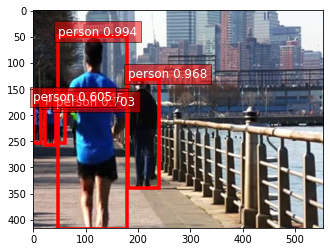

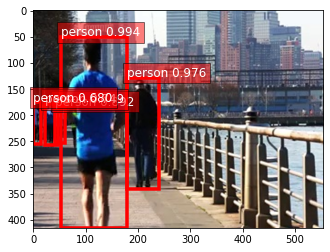

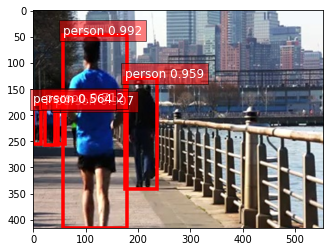

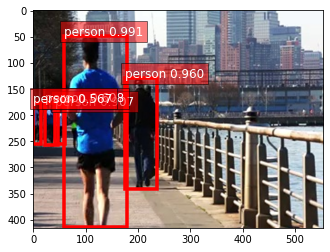

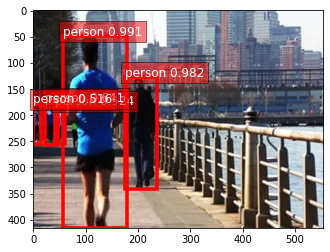

In [36]:
axes = None
NUM_FRAMES = 5 # you can change this
for i in range(NUM_FRAMES):
    # Load frame from the camera
    hasFrame, frame = cap.read()
    if hasFrame:
        cv2.imwrite("image.jpg", frame)
        # Run frame through network
        box_ids, scores, bboxes = detect("image.jpg", predictor)
        # Image processing
        with open("image.jpg", 'rb') as image:
            f = image.read()
        im_array = mx.image.imdecode(f)
        # Run YOLO pre-processing on CPU
        _, image = gcv.data.transforms.presets.yolo.transform_test(im_array)
    
        # Display the result
        # img = gcv.utils.viz.cv_plot_bbox(frame, bboxes[0], scores[0], box_ids[0], class_names=classes)
        utils.viz.plot_bbox(image, bboxes[0], scores[0], box_ids[0], class_names=classes) #, thresh=0.9)
        # gcv.utils.viz.cv_plot_image(img)
        # cv2.waitKey(1)

## Delete the SageMaker Endpoint after this demo

In [ ]:
# sess.delete_endpoint(endpoint_key)